In [ ]:
Dockerfile Usage

In [ ]:
1 Info
Docker 可以通过读取 Dockerfile 指令自动生成 image。
Dockerfile 文件是一个文本文档，包含用户在构建 image 时可以在命令行上调用的所有命令。
使用 docker build 可以创建一个自动构建，该指令会连续执行 Dockerfile 文件定义的命令行指令。

In [ ]:
2 Usage
docker build 命令会根据一个 Dockerfile 文件和上下文来构建镜像。
上下文指的是在指定位置的文件集合，可以是 PATH 或 URL。
PATH 是本地文件系统上的一个目录，URL 是一个 Git 仓库的位置。

In [ ]:
2.1 context
上下文会被递归的处理。因此 PATH 可以包含任何子目录，URL 可以包含存储库及其子模块。
# 以当前目录作为上下文的构建命令
$ docker build .
# 显示
Sending build context to Docker daemon 6.51 MB
...

In [ ]:
2.2 build
构建由 Docker守护程序（Docker daemon）运行，不是由 CLI 运行。
构建过程所做的第一件事是将整个上下文（递归地）发送到守护进程。
在大多数情况下，最好以空目录作为上下文，并将Dockerfile保存在该目录中。
即目录中只包含 Dockerfile 文件本身和构建 Dockerfile 所需的文件。
** 警告：不要使用根目录， / 作为 PATH 会把硬盘驱动器所有内容挂载到 daemon，危险！

In [ ]:
2.2.1 Dockerfile 指令
如果要在构建时使用上下文中的某个文件，可以通过 Dockerfile 引用指令来指定文件，例如 COPY 指令。
为了增加构建的性能，可以通过将.dockerignore 文件添加到上下文目录来排除文件和目录。

In [ ]:
默认情况下，Dockerfile被称为Dockerfile并位于上下文的根目录。
也可以使用 -f 参数指定 docker build 指向 HOST 文件系统中任何位置的Dockerfile 文件。
$ docker build -f /path/to/a/Dockerfile .
构建成功后，可以指定一个存储库（镜像名）和标签来保存新镜像：
$ docker build -t shykes/myapp .
若想要在构建完成后将镜像标记到多个存储库中，请在运行build命令时添加多个 -t 参数：
$ docker build -t shykes/myapp:1.0.2 -t shykes/myapp:latest .
在 docker daemon 运行 Dockerfile 中的指令之前，会执行 Dockerfile 的初步验证，如果语法不正确会报错：
$ docker build -t test/myapp .
Sending build context to Docker daemon 2.048 kB
Error response from daemon: Unknown instruction: RUNCMD

In [ ]:
Docker守护进程逐个运行Dockerfile中的指令，在必要时将每条指令的结果提交给新镜像，最后输出新镜像的ID 。
Docker守护进程将自动清理发送的上下文。
** 每条指令都是独立运行的，并且会创建一个新的镜像，所以RUN cd /tmp不会对下一条指令产生任何影响。
只要有可能，Docker将重新使用中间镜像（缓存），以显着加速docker build过程。这是由Using cache控制台输出中的消息指示：
$ docker build -t svendowideit/ambassador .
Sending build context to Docker daemon 15.36 kB
Step 1/4 : FROM alpine:3.2
 ---> 31f630c65071 # 中间镜像 1
Step 2/4 : MAINTAINER SvenDowideit@home.org.au
 ---> Using cache
 ---> 2a1c91448f5f # 中间镜像 2
Step 3/4 : RUN apk update &&      apk add socat &&        rm -r /var/cache/
 ---> Using cache
 ---> 21ed6e7fbb73 # 中间镜像 3
Step 4/4 : CMD env | grep _TCP= | (sed 's/.*_PORT_\([0-9]*\)_TCP=tcp:\/\/\(.*\):\(.*\)/socat -t 100000000 TCP4-LISTEN:\1,fork,reuseaddr TCP4:\2:\3 \&/' && echo wait) | sh
 ---> Using cache
 ---> 7ea8aef582cc  # 最终镜像
Successfully built 7ea8aef582cc # 最终镜像
构建缓存仅用于具有本地父链（父镜像）的镜像。
这意味着这些镜像是由以前的版本创建的，或者是整个镜像链通过docker load加载的。
如果希望使用特定镜像的构建缓存，则可以使用--cache-from选项指定它。
通过--cache-from指定的镜像不需要有父链，它可以从其他registries中提取。

In [ ]:
当构建完成后，就可以将其 push 到 registries 中。

In [ ]:
3 format
Dockerfile 文件的格式：
# comment
INSTRUCTION arguments
指令不区分大小写。但是为了方便将指令和参数区分开，约定指令为大写。
Docker 按顺序运行Dockerfile 中的指令。**一个Dockerfile 文件必须从FROM指令开始**。
该FROM指令指定了正在构建的基础镜像。FROM只能在该行所有参数之前。

In [ ]:
Docker 将会把以 "#" 开始的行当做注释，除非该行是一个有效的解析器指令（加上单引号）。
在解析器指令行中其他任何地方的 "#" 标记都被视为参数，例如
# Comment
RUN echo 'we are running some # of cool things'

In [ ]:
3.1 不支持的解析器指令
（1）注释中不支持换行符，下面的代码因为注释的行连续而无效
    # direc \
    tive=value
（2）解析器指令是可选的，并影响该Dockerfile中后续行的处理方式。解析器指令不会向构建中添加任何镜像层，也不会显示为构建步骤。
    解析器指令在表单中被写为特殊类型的注释，标志为：
    # directive=value。
    一个指令只能使用一次注释，出现两次时解析器指令则无效：
    # directive=value1
    # directive=value2
    FROM ImageName
（3）所有的解析器指令都必须位于 Dockerfile 最顶端，在构造者指令之后则无效：
    FROM ImageName
    # directive=value
（4）一旦注释，空行或构建器指令被处理，Docker将不再查找解析器指令。相反，它将任何分析器指令格式的指令视为注释，而不会尝试验证它是否可能是解析器指令。
    在不是解析器指令的注释之后出现，docker 不会再查找解析器标志，而是作为注释处理：
    # About my dockerfile
    # directive=value
    FROM ImageName
（5）由于在不是解析器指令的注释之后出现，已知的指令被视为注释。
    # unknowndirective=value
    # knowndirective=value
（6）解析器指令中允许使用非换行符空格，以下几行都是一样的：
    #directive=value
    # directive =value
    #	directive= value
    # directive = value
    #	  dIrEcTiVe=value

In [ ]:
3.2 支持的解析器指令
escape指令用于设置 Dockerfile 中的转义字符。如果未指定，则默认转义字符为\。例如：
    # escape = \
    # escape = `
转义字符既用于转义一行中的字符，也用于转义换行符。这允许Dockerfile指令跨越多行。
但是无论escape解析器指令是否包含在Dockerfile 中，转义都不会在RUN命令中执行，除非在行的末尾。
将转义字符设置为`，在windows中很有用，因为 \ 会被当作windows目录路径的分隔符。例如下面一定会失败：
    FROM microsoft/nanoserver
    COPY testfile.txt c:\\
    RUN dir c:\
通过添加escape解析器指令，可以按照以下方式Dockerfile成功地使用适应Windows平台的文件路径语义：   
    # escape=`
    FROM microsoft/nanoserver
    COPY testfile.txt c:\
    RUN dir c:\

In [ ]:
3.3 环境变量
环境变量（用ENV语句声明）也可以在某些指令中用作由Dockerfile解释的变量。转义也会被处理，从字面上包含类似于变量的语法。
Dockerfile 中的环境变量用 $variable_name 或者 ${variable_name} 来标记。
    ${variable_name}语法还支持一些标准 bash 修饰符，如下所示：
    ${variable:-word}表示如果变量 variable 被设置，则结果将是该值。如果变量variable没有设置，那么word将是结果值。
    ${variable:+word}表示如果 variable 设置则返回word结果，否则结果为空字符串。
    在任何情况下，word都可以是任何字符串，包括其他环境变量。
通过在变量前面添加转义符 \ 来实现转义，例如：
    \$foo或\${foo}将分别转换为$foo和$ {foo}文字,而不是作为变量。示例（# 之后显示的为解析结果）：
    FROM busybox
    ENV foo /bar
    WORKDIR ${foo}   	# WORKDIR /bar
    ADD . $foo       	# ADD . /bar
    COPY \$foo /quux 	# COPY $foo /quux
Dockerfile 中的以下指令都支持环境变量：
    ADD
    COPY
    ENV
    EXPOSE
    FROM
    LABEL
    STOPSIGNAL
    USER
    VOLUME
    WORKDIR
    以及：
    ONBUILD （当与以上支持的指令结合使用时）

In [ ]:
3.4 .dockerignore 文件
在docker客户端（CLI）将上下文发送到docker守护程序之前，它会查找上下文根目录中的.dockerignore 文件。
如果此文件存在，CLI会修改上下文以排除与.dockerignore 文件中的模式匹配的文件和目录。这有助于避免不必要地将大型或敏感文件和目录发送到守护程序，
而是尽可能地使用 ADD 或 COPY 将其添加到镜像。
CLI将.dockerignore 文件解释为一个以换行符分隔的模式列表，类似于Unix shell的文件格式。为了匹配的目的，上下文的根被认为是工作目录和根目录。
例如，模式 /foo/bar和foo/bar会在PATH路径下的foo子目录或位于URL地址的git存储库的根目录中排除名为bar的文件或目录，但是不会排除其他任何东西。
如果.dockerignore 文件中的某一行以"#"开头，则此行被视为注释，并在被CLI解释之前被忽略。例如：
    # comment
    */temp*
    */*/temp*
    temp?

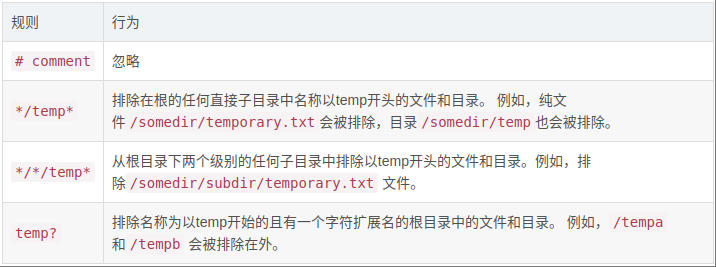

In [2]:
# 此.dockerignore 文件将导致以下构建行为：
from IPython.display import Image
Image(filename="dockerignore.jpg",width=500,height=500)

In [ ]:
.dockerignore 的匹配（预处理）使用的是 Go 的 filepath.Match 规则完成的。 预处理步骤使用Go的filepath.Clean 删除前导和尾随空白，并消除 . 和 .. 。 预处理后空白的行将被忽略。
除了Go的filepath.Match 规则，Docker还支持一个特殊的通配符**，匹配任意数量的目录（包括零）。例如：
    ** / *.go 将排除所有目录中包含的.go 结尾的所有文件，包括构建上下文的根目录。
以!(感叹号)开始的行可以用来排除例外情况,以下.dockerignore 文件是使用此机制的示例：
    *.md
    !README.md # 除README.md之外的所有md(markdown)文件都将从上下文中排除。

In [ ]:
3.5 ！的异常行为
.dockerignore 的最后一行负责匹配特定文件并确定是否包含或排除(其实就是逐行处理)。
# 示例 1
    *.md
    !README*.md
    README-secret.md
# 示例 2
    *.md
    README-secret.md
    !README*.md
示例1：除了 README-secret.md 之外的其他 README 文件，上下文中不包括任何 md 文件。
示例2：所有的README文件都包含在内。中间行(README-secret.md)不起作用，因为！README * .md 匹配 README-secret.md 并且是最后一行。
参见 .dockeringore.txt 文档。

In [ ]:
甚至可以使用.dockerignore 文件来排除 Dockerfile 和.dockerignore 文件。 
这些文件仍然被发送到守护进程，因为它需要它们来完成它的工作。 
但ADD和COPY指令不会将它们复制到镜像中。
如果需要指定哪些文件包含在上下文中，而不是要排除的文件。 
要实现这一点，请将*指定为第一个模式，然后再指定一个或多个 ! 例外模式。

In [ ]:
4 FROM
FROM指令初始化一个新的构建过程并为后续指令设置基础映像。 因此，有效的Dockerfile 文件必须以FROM指令开始。镜像可以是任何有效的镜像。
    # FROM 的指令格式
    FROM <image> [AS <name>]
    FROM <image>[:<tag>] [AS <name>]
    FROM <image>[@<digest>] [AS <name>]
指令说明：
-ARG 可能是Dockerfile中位于FROM之前的唯一指令；
-FROM可以在单个Dockerfile文件中多次出现以创建多个镜像或将一个构建阶段用作另一个构建阶段的依赖关系。只需在每个新的FROM指令之前记录提交输出的最后一个镜像ID。每条FROM指令清除以前指令创建的任何状态。
-通过将AS名称添加到FROM指令，可以给新的构建过程赋予一个名称。该名称可用于后续的FROM和COPY --from = <name | index>指令以引用此阶段中构建的镜像。
-标签或摘要值是可选的，默认情况下，构建器会采用latest的标记。 如果无法找到标记值，构建器将返回错误。

In [ ]:
4.1 ARG 和 FROM 交互
FROM 指令支持由第一个FROM之前发生的任何ARG指令声明的变量。
    ARG  CODE_VERSION=latest
    FROM base:${CODE_VERSION}
    CMD  /code/run-app
    FROM extras:${CODE_VERSION}
    CMD  /code/run-extras
在FROM之前声明的ARG在构建阶段之外，所以它不能在FROM之后的任何指令中使用。 
要使用在第一个FROM之前声明的ARG的默认值，要在构建阶段内使用没有值的ARG指令：
    ARG VERSION=latest
    FROM busybox:$VERSION
    ARG VERSION # 没有复制，在 RUN 中以 ${VERSION} 形式写入 image_version 中
    RUN echo $VERSION > image_version

In [ ]:
5 RUN
# 命令形式有两种
RUN <command> (shell形式，RUN命令在shell中运行，默认是linux上的 /bin/sh -c 或windows上的 cmd /S/C)
RUN ["exectuable","param1","param2"](exec形式)
RUN指令将执行当前镜像顶部的新镜像层中的任何命令并提交结果。生成的提交镜像将用于 Dockerfile 中的下一步。
分层运行指令和生成提交符合Docker的核心概念，其中提交很方便，容器可以从镜像历史中的任意点创建，与源代码控制非常相似。
exec形式可以避免shell字符串的转换，并且可以使用不包含指定的可执行shell的基础映像运行命令。

In [ ]:
5.1 shell形式
对于shell形式的默认shell可以使用SHELL命令进行更改。
在shell形式中，可以使用\（反斜杠）将单个RUN指令继续到下一行。 例如，考虑这两行：
    RUN /bin/bash -c 'source $HOME/.bashrc; \
    echo $HOME'
等同于：RUN /bin/bash -c 'source $HOME/.bashrc; echo $HOME'
- /bin/bash 表示 bash 的可执行文件路径；
-c 表示从字符串中读取命令并执行，命令字符串：'source $HOME/.bashrc; echo $HOME'
-source 是一个 Bash 内置命令，用于在当前 Shell 环境中读取并执行指定文件（$HOME/.bashrc ）中的命令
-$HOME 是一个环境变量，默认表示用户的主目录（例如 /home/<username> 或 /root）
-.bashrc 是 Bash 的配置文件，通常包含一些用户定义的环境变量、别名或函数。
-echo 是一个常用的命令，用于将变量或文本输出到终端，$HOME 是一个环境变量，表示用户的主目录。
指令作用：
使用 Bash Shell 来执行一段命令。
首先加载用户的 Bash 配置文件 ~/.bashrc ，以确保当前环境变量、别名等设置被加载。
然后输出 $HOME 环境变量的值。
**注意：要使用不同于'/bin/sh'的shell，请使用传递所需shell的exec形式。 例如，RUN [“/ bin / bash”，“-c”，“echo hello”]
**注意：exec形式将被解析为JSON数组，这意味着必须在单词周围使用双引号（“）,而非单引号（'）。
**注意：与shell形式不同，exec形式不会调用命令shell。这意味着正常的shell处理不会发生。 例如，RUN [“echo”，“$HOME”]不会在$HOME上执行变量替换。如果想要shell处理，那么要么使用shell的形式，要么直接执行一个shell，例如：RUN [“sh”，“-c”，“echo $HOME”]。 当使用exec形式并直接执行一个shell时（如shell格式的情况），它是在执行环境变量扩展的shell，而不是docker。


In [ ]:
RUN指令缓存在下一次构建期间不会自动失效。像RUN apt-get dist-upgrade -y这样的指令的缓存将在下一次构建时重用。
RUN指令缓存可以通过使用--no-cache标志失效，例如docker build --no-cache。

In [ ]:
6 CMD
Dockerfile中只能有一个CMD指令。 如果列出多个CMD，则只有最后一个CMD才会生效。
CMD 指令有三种形式：
CMD ["executable","param1","param2"] # exec 形式，首选
CMD ["param1","param2"] # 使用默认参数 ENTRYPOINT
CMD command param1 param2 # shell 形式
CMD的主要目的是为执行容器提供默认值。这些默认值可以包含可执行文件，或者可以省略可执行文件，在这种情况下，必须指定ENTRYPOINT指令。
**如果使用CMD为ENTRYPOINT指令提供默认参数，则应使用JSON数组格式使用CMD和ENTRYPOINT指令。
当以 shell 或 exec 格式使用 CMD 时，CMD指令设置运行镜像时要执行的命令。

In [ ]:
如果使用CMD的shell形式，那么 <command> 将在 /bin/sh -c 中执行：
    FROM ubuntu
    CMD echo "This is a test." | wc -
- | 是管道符（pipe），作用是将前一个命令的输出（stdout）作为后一个命令的输入（stdin）。echo "This is a test." 的输出被传递给 wc - 命令。
- wc 是 word count，用于统计（count）行数、单词数和字节数，-表示将从标准输入中读取数据，而不是从文件中读取。
- 即 使用 echo 命令输出一行文本："This is a test."。通过管道（|）将这行文本传递给 wc。wc 统计这行文本的行数（1）、单词数（4）和字符数（16）。

In [ ]:
如果要在没有shell情况下运行<command>，那么需要将该命令表示为JSON数组并给出可执行文件的完整路径。
**这种数组形式是CMD的首选格式，任何附加参数都必须单独表示为数组中的字符串。
    FROM ubuntu
    CMD ["/usr/bin/wc","--help"]
如果希望容器每次都运行相同的可执行文件，那么应该考虑将ENTRYPOINT与CMD结合使用。
如果用户指定docker run运行的参数，那么它们将覆盖CMD中指定的默认值。
**不要将RUN与CMD混淆。
**RUN实际上运行一个命令并提交结果; CMD在构建时不执行任何操作，但是指定了运行镜像的预期命令。

In [ ]:
7 LABEL
LABEL指令的作用是为镜像添加元数据。LABEL是一个键值对形式，命令形式：
LABEL <key>=<value> <key>=<value> <key>=<value> ...
如果要在 LABEL 值中包含空格，就需要在命令行解析中一样使用 ` 或者 \

In [ ]:
# 用法示例
LABEL "com.example.vendor"="ACME Incorporated"
LABEL com.example.label-with-value="foo"
LABEL version="1.0"
LABEL description="This text illustrates \
that label-values can span multiple lines."

In [ ]:
一个镜像可以有多个label,即在但个指令中指定多个标签：
LABEL multi.label1="value1" multi.label2="value2" other="value3"
or
LABEL multi.label1="value1" \
      multi.label2="value2" \
      other="value3"

In [ ]:
包含在基础镜像（FROM 行指定的镜像）或父镜像中的标签由子镜像继承。
如果标签已经存在但使用不同的值，则最近应用的值将覆盖任何先前设置的值。
** 使用 docker inspect 命令查看镜像标签
"Labels": {
    "com.example.vendor": "ACME Incorporated"
    "com.example.label-with-value": "foo",
    "version": "1.0",
    "description": "This text illustrates that label-values can span multiple lines.",
    "multi.label1": "value1",
    "multi.label2": "value2",
    "other": "value3"
},

In [ ]:
8 MAINTAINER
MAINTAINER 指令设置生成镜像的作者字段。更建议用 LABEL
 # 语法结构
 MAINTAINER <name>
相比 MAINTAINER，LABEL指令是一个更灵活的版本，并且很容易使用 docker inspect 指令查看。
 LABEL maintainer="SvenDowideit@home.org.au"

In [ ]:
9 EXPOSE
EXPOSE 通知 Docker，该容器在运行时监听指定的网络端口。端口协议可以是 TCP 或者 UDP，如果未指定协议，则默认为 TCP。
 #语法结构
 EXPOSE <port> [<port>/<protocol>...]
EXPOSE指令并不实际发布该端口。用作构建镜像的人与运行容器的人之间的关于哪些端口打算发布的文档。
要在运行容器时(docker run )指定实际发布端口，使用-p标志发布和映射一个或多个端口，或者使用-P标志发布所有公开的端口并将它们映射到高阶端口。
docker network命令支持为容器之间的通信创建网络，而无需公开或发布特定端口，因为连接到网络的容器可以通过任何端口相互通信。

In [ ]:
10 ENV
ENV指令将环境变量<key>设置为该值 <value>。该值将在所有后代 Dockerfile 命令的环境中可用，并可以在许多内联中被替换。
 # 语法结构
 ENV <key> <value>
 ENV <key>=<value> ...
第一种形式是ENV <key> <value>，将一个变量设置为一个值。第一个空格之后的整个字符串将被视为<value>- 包括空格和引号之类的字符。
第二种形式ENV <key>=<value> ...允许一次设置多个变量。与命令行解析一样，引号和反斜杠可用于包含值中的空格。
例如：
    ENV myName="John Doe" myDog=Rex\ The\ Dog \
    myCat=fluffy
和
    ENV myName John Doe
    ENV myDog Rex The Dog
    ENV myCat fluffy
两种指令形式在最终镜像中产生相同的结果，但第一种形式是首选，因为它会生成单个缓存层。
使用ENV设置的环境变量将在从结果镜像运行容器时保留。
可以使用docker inspect命令查看这些值，并使用docker run --env <key>=<value>进行更改。
** 注意 **
环境变量持久性可能会导致意想不到的副作用。
例如，设置ENV DEBIAN_FRONTEND noninteractive可能会将apt-get用户混淆在基于Debian的镜像上。
要为单个命令设置一个值，请使用 RUN <key>=<value> <command>。

In [ ]:
11 ADD
ADD 指令的作用是从源代码路径 <src> 中复制新文件、目录或远程文件URL，并添加到镜像文件系统中的路径 <dest>。
ADD 有两种指令形式：
ADD [--chown=<user>:<group>] <src>...<dest>
ADD [--chown=<user>:<group>] ["<src>",..."<dest>"](这种形式对于包含空格的路径是必须的)
*--chown 功能仅在用于构建Linux容器的Dockerfiles上被支持，并不适用于Windows容器。
可以指定多个<src>资源，但如果它们是文件或目录，则它们的路径将被解释为构建上下文的相对来源。

In [ ]:
每个<src>可以包含通配符，并且使用Go的filepath.Match 规则完成匹配。例如：
ADD hom* /mydir/        # adds all files starting with "hom"
ADD hom?.txt /mydir/    # ? is replaced with any single character, e.g., "home.txt"

In [ ]:
<dest>是绝对路径或相对于WORKDIR的相对路径，源地址的内容将复制到目标容器内该路径中。
ADD test relativeDir/          # adds "test" to `WORKDIR`/relativeDir/
ADD test /absoluteDir/         # adds "test" to /absoluteDir/

In [ ]:
添加包含特殊字符（例如[和]）的文件或目录时，需要按照Golang规则转义这些路径，以防止它们被视为匹配模式。
例如，要添加一个名为 arr[0].txt 的文件，请使用以下内容：
ADD arr[[]0].txt /mydir/    # copy a file named "arr[0].txt" to /mydir/

In [ ]:
除非使用可选的--chown标志指定用户名，组名或UID / GID组合来请求所添加内容的特定所有权，否则所有新文件和目录均使用UID和GID 0创建。
关于 --chown 使用 参考 chown.txt。

In [ ]:
如果容器的根文件系统不包含任何 /etc/passwd 或 /etc/group 文件，并且在 --chown 标志中使用了用户名或组名，则构建将在 ADD 中失败。
如果使用数字标识，则不需要查找，也不依赖容器根文件系统内容。
如果<src>是远程文件URL，则目标将具有600的权限。如果正在检索的远程文件具有HTTP Last-Modified标头，则将使用该标头的时间戳来设置目标文件上的mtime时间戳。
但是，与在ADD期间处理的任何其他文件一样，mtime将不会包含在文件是否已更改以及缓存应该更新的确定中。

In [ ]:
11.1 ADD 注意事项
（1）如果通过 STDIN 传递 Dockerfile(docker build - < somefile)来构建，则没有构建上下文，因此 Dockerfile 只能包含基于URL的ADD指令。
（2）如果希望在 STDIN 构建时传入上下文，可以通过 STDIN 传递一个压缩文档 (docker build - < archive.tar.gz)，压缩文档根目录的Dockerfile和其余部分将用作构建的上下文。
（3）如果url文件使用认证保护，由于ADD指令不支持认证，需要使用 RUN wget, RUN curl 或其它工具。
（4）如果<src>的内容已更改，则第一次遇到的ADD指令使缓存中所有后续指令无效，包括使RUN指令缓存无效。

In [ ]:
11.2 ADD rules
（1）<src> 路径必须位于构建的上下文中，即 <src> 的路径必须在 Dockerfile 文件根目录或其子目录中；
（2）不能 ADD ../something/something,因为 docker build的第一步是将上下文目录和子目录发送到docker守护进程（docker daemon），上下文是当前工作目录，从dockerfile所在位置开始算，../ 意味着已经到了根目录的上级。
（3）如果<src>是一个URL并且<dest>不以斜杠结尾（例如<dest>=/locoman，不加斜杠意味着是一个文件），那么文件将从URL下载并复制到<dest>；
（4）如果<src>是一个URL，并且<dest>以斜杠结尾（即路径），则从URL推断出文件名，并将该文件下载到<dest>/<filename>。
例如，ADD http://example.com/foobar /  会创建文件夹 /foobar。该URL必须有一个有效的路径，以便找到适当的文件名（http://example.com 将不起作用）。
（5）如果是目录，则复制目录的全部内容，包括文件系统元数据。目录本身不被复制，只是复制它的内容。（即只复制文件）
（6）如果<src>是一个可识别的本地压缩归档文件（identity，gzip，bzip2或xz），那么它将被解压缩为一个目录。 来自远程URL的资源不被解压缩。
（7）如果<src>是任何其他类型的文件，则将其与其元数据一起单独复制。 在这种情况下，如果<dest>以斜杠/结尾，则它将被视为一个目录，<src>的内容将写入<dest>/base（<src>）。
（8）如果指定了多个<src>资源（直接或使用通配符），则<dest>必须是目录，并且必须以斜杠`/结尾。
（9）如果<dest>不以斜杠结尾，则它将被视为常规文件，<src>的内容将写入<dest>
（10）如果<dest>不存在，则会在其路径中创建所有缺少的目录。

In [ ]:
11.3 ADD example
在 Docker 的 Dockerfile 中，ADD 指令用于将文件、目录或远程文件 URL 复制到镜像中的指定路径。
当操作对象是一个目录时，ADD 会复制目录的全部内容（包括其子目录和文件）以及相关的元数据。
ADD 指令递归地将源目录下的所有文件和子目录复制到目标路径中。例如：
ADD ./src /app/src # 将本地目录 src 中的所有内容复制到镜像中的 /app/src 目录中
ADD 的特点是复制目录的全部内容以及文件系统的元数据（包括文件权限、所有者、修改时间等）
假设本地目录结构如下：
    project/
    ├── app
    │   ├── index.js
    │   └── package.json
    ├── logs
    │   └── access.log
    └── Dockerfile
在 Dockerfile 中使用 ADD ./app /app
构建镜像后：（1）/app 目录中会包含 index.js 和 package.json 文件；（2）如果 index.js 有可执行权限，镜像中的 /app/index.js 也会保留这些权限。
# 如果目标路径不存在，ADD 会自动创建目标目录
# 如果源目录中包含符号链接，ADD 会自动解析符号链接，并将实际文件或目录的内容复制到镜像中（而不是复制符号链接本身）
# 如果源目录是从远程 URL 下载的（ADD http://example.com/file /app），Docker 会自动下载并将其内容复制到镜像中

In [ ]:
12 COPY
ADD 和 COPY 的区别：
相比ADD，COPY更加直接，只复制文件或者目录到容器里。COPY不支持URL，如果build上下文中没有指定解压的话，也不会自动解压，只会将压缩文件复制到容器中。
COPY是ADD的一种简化版本，目的在于满足“复制文件到容器”的需求。
Docker的建议是大多数情况下使用COPY，除非明确需要ADD。

In [ ]:
COPY指令从<src>中复制文件或目录，并添加到容器文件系统中的路径<dest>处。
# COPY语法结构
COPY [--chown=<user>:<group>] <src>... <dest>
COPY [--chown=<user>:<group>] ["<src>",... "<dest>"] （此形式对于包含空格的路径是必需的）
COPY可以指定多个<src>资源，但文件和目录的路径将被解释为相对于构建（dockerfile）的上下文来源(上下文根目录,即Dockerfile文件所属的目录)。

In [ ]:
COPY指令中，<src>同样可以包含通配符，也同样使用Go的filepath.Match 规则完成匹配。
COPY hom* /mydir/        # adds all files starting with "hom"
COPY hom?.txt /mydir/    # ? is replaced with any single character, e.g., "home.txt"
<dest>是绝对路径或相对于WORKDIR的相对路径，源地址的内容将复制到目标容器内的指定路径中。
COPY test relativeDir/   # adds "test" to `WORKDIR`/relativeDir/
COPY test /absoluteDir/  # adds "test" to /absoluteDir/
复制包含特殊字符（例如[和]）的文件或目录时，需要按照Golang规则转义这些路径，以防止它们被视为匹配模式。
例如，要添加一个名为arr[0].txt 的文件，使用：
COPY arr[[]0].txt /mydir/    # copy a file named "arr[0].txt" to /mydir/
--chown的用法与ADD一样：
COPY --chown=55:mygroup files* /somedir/
COPY --chown=bin files* /somedir/
COPY --chown=1 files* /somedir/
COPY --chown=10:11 files* /somedir/
如果<src>是远程文件URL，则目标将具有600的权限。如果正在检索的远程文件具有HTTP Last-Modified标头，则将使用该标头的时间戳来设置目标文件上的mtime时间戳。
但是，与在ADD期间处理的任何其他文件一样，mtime将不会包含在文件是否已更改以及缓存应该更新的确定中。
如果通过STDIN传递Dockerfile（docker build - < somefile）来构建，则没有构建上下文，因此COPY不能使用。

In [ ]:
COPY可以接受一个标志参数--from=<name|index>，该参数可用于将源位置设置为之前的构建阶段（使用创建的FROM .. AS <name>），这将用于代替用户发送的构建上下文。
该标志还接受为以FROM指令开始的所有以前的构建阶段分配的数字索引。
如果无法找到具有指定名称的构建阶段，则尝试使用具有相同名称的镜像。

In [ ]:
12.1 COPY rules
（1）与ADD一样，路径必须位于构建的上下文中，不能够COPY ../something / something,因为docker build 的第一步是将上下文目录和子目录发送到docker daemon。
（2）如果是目录，则复制包含文件系统元数据在内的目录全部内容（目录本身不会复制，只复制内容）
（3）如果<src>是任何其他类型的文件，则将其与其元数据一起单独复制。 在这种情况下，如果<dest>以斜杠/结尾，则它将被视为一个目录，<src>的内容将写入<dest>/base（<src>）。
（4）如果指定了多个<src>资源（或直接使用通配符），则<dest>必须是目录，并且必须以斜杠`/结尾。
（5）如果<dest>不以斜杠结尾，则它将被视为常规文件，<src>的内容将写入<dest>。
（6）如果<dest>不存在，则会在其路径中创建所有缺少的目录。

In [ ]:
13 VOLUME
VOLUME 指令创建一个具有指定名称的挂载点，并将其标记为从本机主机或其他容器中存储外部安装的卷。
核心作用—让容器的某些数据可以独立于容器本身存在，避免容器重启或删除时数据丢失，特别是配置文件、日志文件和数据库文件等需要长期保存的数据。
#语法结构
VOLUME ["/path/to/volume1", "/path/to/volume2"]
    -语法中使用的绝对路径代表容器内需要挂载为卷的目录；
    -目录可以是一个或多个（逗号分隔）

In [ ]:
13.1 VOLUME examples
 # 假设一个 Dockerfile
    FROM alpine
    VOLUME ["/app/data"]
    CMD ["sh", "-c", "echo 'Hello World' > /app/data/output.txt"]
 # 构建镜像
    docker build -t myimage .
 # 运行容器
    docker run -d --name mycontainer myimage
** 注意，如果在构建镜像后又希望向卷中添加数据，可以通过 -v 参数覆盖卷的内容：
    docker run -v host/directory:/app/data myimage
    -使用 -v 参数挂载的卷将覆盖 Dockerfile 中通过 VOLUME 定义的卷。
13.2 volume 命令管理
列出卷：docker volume ls
删除卷：docker volume rm <volume_name>
清理无主卷：docker volume prune

In [ ]:
docker run命令使用基础镜像中指定位置存在的任何数据初始化新创建的卷。 
例如，请考虑以下Dockerfile代码片段：
    FROM ubuntu
    RUN mkdir /myvol
    RUN echo "hello world" > /myvol/greeting
    VOLUME /myvol
此Dockerfile会生成一个镜像，导致docker run在/myvol处创建新的挂载点，并将greeting文件复制到新创建的卷中。

In [ ]:
Dockerfile中的注意事项：
（1）基于Windows的容器上的卷：使用基于Windows的容器时，容器内的卷的目标必须是以下之一：
    一个不存在的或空的目录，C以外的驱动器
（2）在Dockerfile中更改卷：如果任何构建步骤在声明后更改了卷内的数据，则这些更改将被丢弃。
（3）JSON格式：列表被解析为JSON数组。必须用双引号（"）括住单词而不是单引号（’）。
（4）主机目录在容器运行时声明：主机目录（挂载点）本质上取决于主机。 这是为了保持镜像的可移植性，因为无法保证给定主机目录在所有主机上都可用。 
因此，不能在Dockerfile中挂载一个主机目录。 
VOLUME指令不支持指定host-dir参数，必须在创建或运行容器时指定挂载点。

In [ ]:
14 USER
USER 指令用来设置用户名(或UID)和可选的用户组(或GID)，以在运行镜像和在dockerfile中执行后续的任何RUN，CMD，ENTRYPOINT指令。
当用户没有主组时，镜像或下一个指令将与root组一起运行。
**在Windows上，如果用户不是内置帐户，则必须先创建用户。 可以通过作为Dockerfile的一部分调用的net user命令来完成：
FROM microsoft/windowsservercore
# Create Windows user in the container
RUN net user /add patrick
# Set it for subsequent commands
USER patrick

In [ ]:
15 WORKDIR
WORKDIR指令为Dockerfile中后面的任何RUN，CMD，ENTRYPOINT，COPY和ADD指令设置工作目录。 
如果WORKDIR不存在，即使未在任何后续的Dockerfile指令中使用它，它也将被创建。
# 语法结构
WORKDIR /path/to/workdir
WORKDIR指令可以在Dockerfile中多次使用。 
如果提供了相对路径，它将相对于以前的WORKDIR指令的路径。 例如：
WORKDIR /a
WORKDIR b
WORKDIR c
RUN pwd
这个Dockerfile中最终的pwd命令的输出是/a/b/c

In [ ]:
15.1 WORKDIR 与 ENV 的关系
WORKDIR指令可以解析先前使用ENV指令设置的环境变量。只能使用在Dockerfile中显式设置的环境变量。
ENV DIRPATH /path
WORKDIR $DIRPATH/$DIRNAME
RUN pwd
此Dockerfile中最终pwd命令的输出将是/path/$DIRNAME